# Artifical lighting control challenge

Green house climate data was used for a supervised machine learning to predict the condition in greenhouse that light should be turn on or off.

## Data exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 2000)

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

import process_ML as pm
import ultil as ut

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [3]:
import plotly.offline as py
import plotly.graph_objs as go

In [4]:
GHclimate = pd.read_parquet('../GreenhouseClimate.parquet')
GHclimate = GHclimate.astype(float)

<AxesSubplot:>

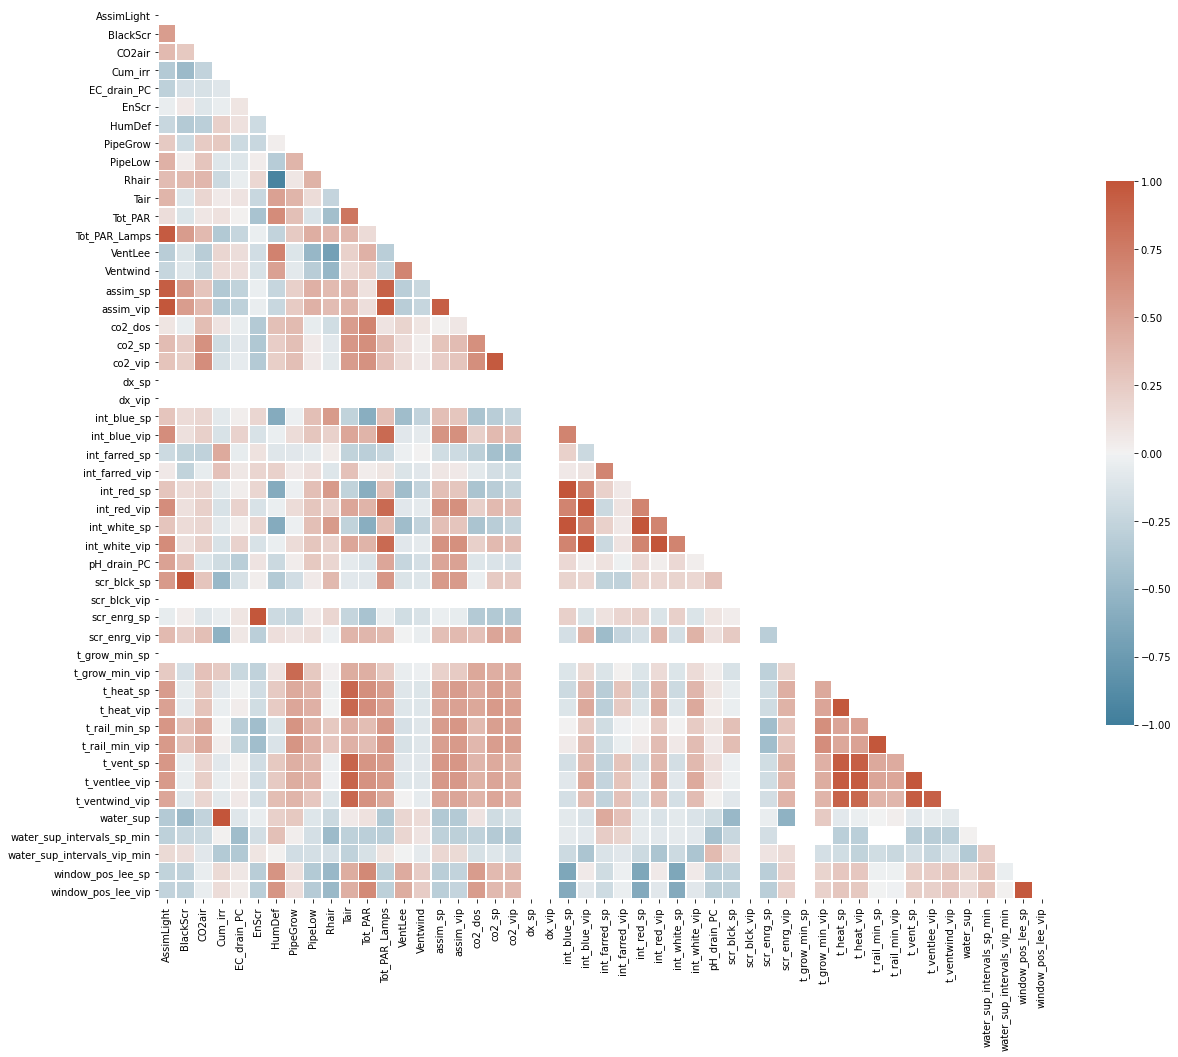

In [5]:
ut.plot_corr(GHclimate.iloc[:,1:],size=20, vmin = -1, vmax = 1, center = 0)

### Check the condition when we turn on and off the light

In [6]:
GHclimate2 = GHclimate.copy()
GHclimate2['light_status'] = GHclimate2.AssimLight.apply(lambda x: 'off' if x == 0.0 else 'on')

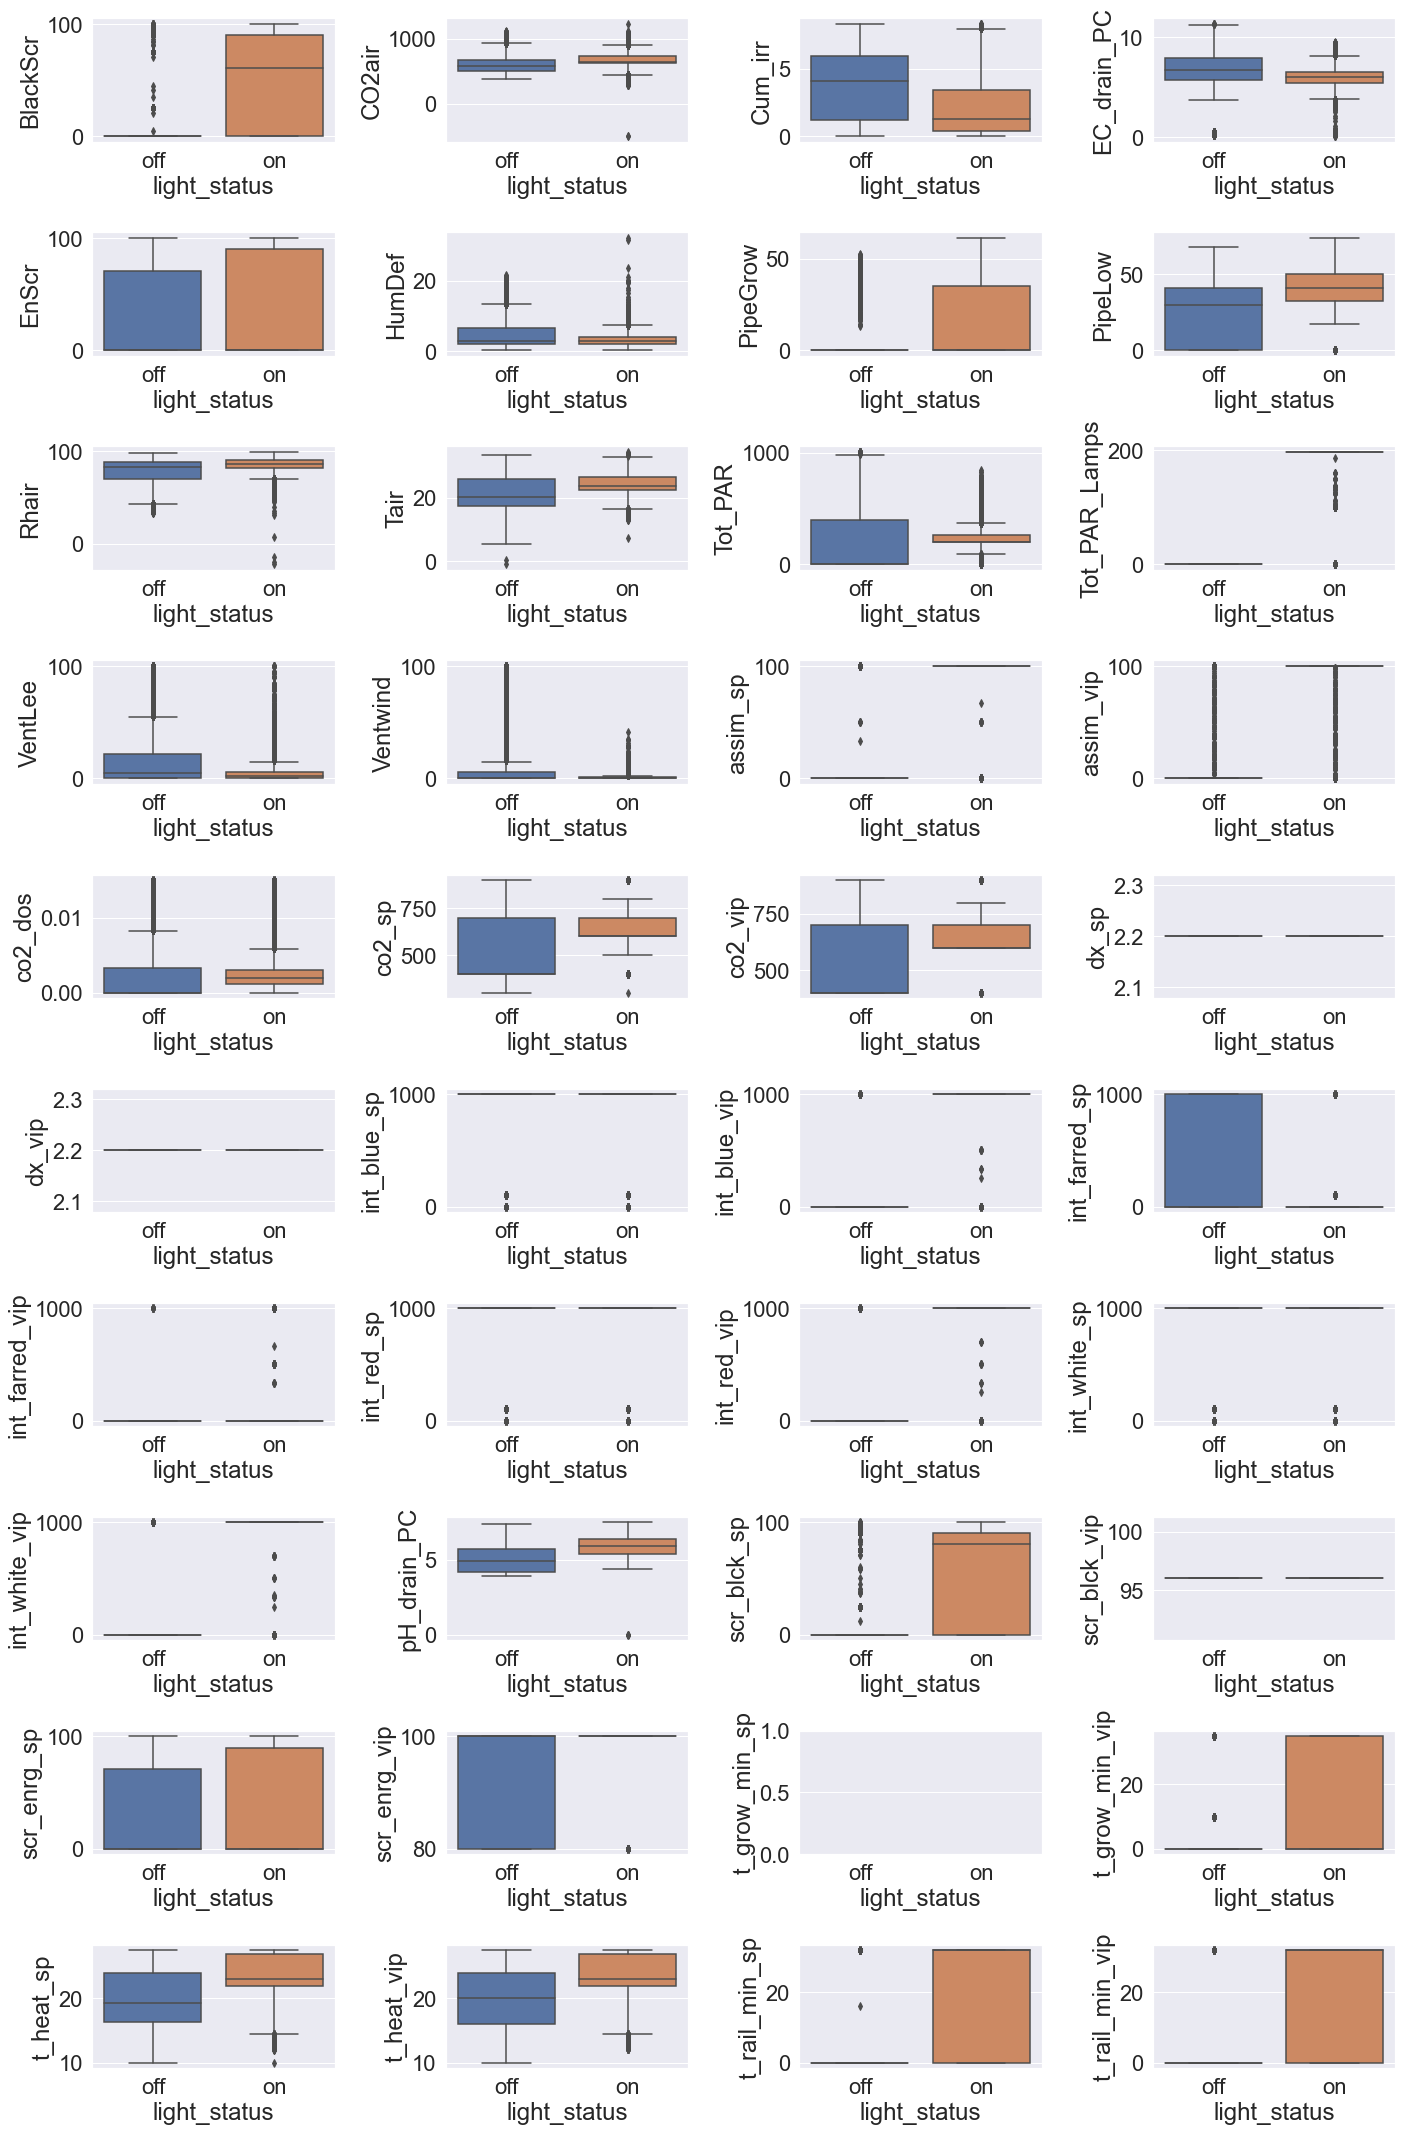

In [7]:
sns.set(font_scale=2)
fig, axes = plt.subplots(10,4, figsize=(20, 30)) # create figure and axes
for i,el in enumerate(list(GHclimate2.columns.values)[2:42]):
    a = sns.boxplot(x= 'light_status', y = el, 
                    data=GHclimate2, 
                    ax=axes.flatten()[i])
plt.tight_layout()
plt.show()

## Data cleaning and preprocessing

### Handle missing value in each column

In [8]:
# remove nan rows in AssimLight column
GHclimate = GHclimate[~GHclimate.AssimLight.isna()]

# Remove column with all NA (t_grow_min_sp)
GH_process = GHclimate.drop(columns=['t_grow_min_sp'])

<AxesSubplot:title={'center':'Missing value ratio'}>

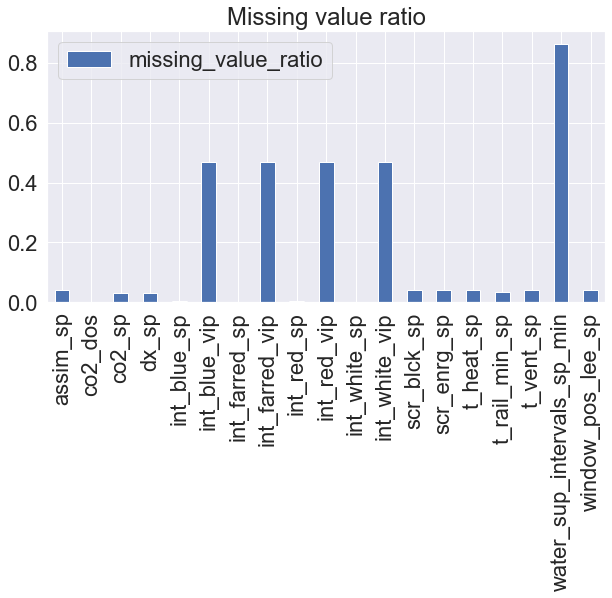

In [9]:
ut.plot_missing_ratio(GH_process)

After checking values count in column water_sup_intervals_sp_min, I decide to use mode to fill NA 

In [10]:
GH_process.water_sup_intervals_sp_min.value_counts()

1950.0    5201
120.0     1277
20.0        21
1010.0       1
2000.0       1
Name: water_sup_intervals_sp_min, dtype: int64

In [11]:
GH_process.water_sup_intervals_sp_min.fillna(GH_process.water_sup_intervals_sp_min.mode()[0], inplace=True)

In [12]:
GH_process.water_sup_intervals_sp_min.mode()[0]

1950.0

Fill NA with mean for column dx_sp, int_blue_sp, int_red_sp, co2_dos

In [13]:
# dx_sp only have one value, thus fill NA with mean
GH_process.dx_sp.fillna(GH_process.dx_sp.mean(), inplace=True)
# NAN in int_blue_sp and int_red_sp are the same index, fill with mean
GH_process.int_blue_sp.fillna(GH_process.int_blue_sp.mean(), inplace=True)
GH_process.int_red_sp.fillna(GH_process.int_red_sp.mean(), inplace=True)
GH_process.co2_dos.fillna(GH_process.co2_dos.mean(), inplace=True)

Remove rows that show CO2air < 0 (there are two rows with -499 CO2air)

In [14]:
GH_process.drop(GH_process[GH_process.CO2air < 0].index, inplace=True)

92% of assim_sp columns has the save value as AssimLight, thus fill NA of assim_sp with AssimLight

In [15]:
ut.match_columns(GH_process, 'assim_sp','AssimLight')

,state,count ratio
0,mach,0.928984
1,no match,0.071016


In [16]:
GH_process.assim_sp.fillna(GH_process.AssimLight, inplace=True)

* 99% of scr_black_sp has the same value as scr_black_vip

In [17]:
ut.match_columns(GH_process, 'scr_blck_sp','scr_blck_vip')

,state,count ratio
0,no match,0.99493
1,mach,0.00507


In [18]:
GH_process.scr_blck_sp.fillna(GH_process.scr_blck_vip, inplace=True)

91% of scr_enrg_sp are the same values as scr_enrg_vip

In [19]:
ut.match_columns(GH_process, 'scr_enrg_sp','scr_enrg_vip')

,state,count ratio
0,no match,0.910654
1,mach,0.089346


In [20]:
GH_process.scr_enrg_sp.fillna(GH_process.scr_enrg_vip, inplace=True)

#### predict co2_sp missing value with linear regression
1. Choose feature columns that do not have NA value
2. Predict NA in co2_sp using linear regression

In [21]:
co2_sp_dat = GH_process[~GH_process.co2_sp.isna()].iloc[:,1:]
column_with_NA = ut.cal_missing_ratio(co2_sp_dat).index.to_list()
co2_sp_dat.drop(columns = column_with_NA, inplace=True)

In [22]:
co2_sp_x = co2_sp_dat.drop(columns=['co2_sp'])
co2_sp_y = co2_sp_dat[['co2_sp']]
lr, Y_predict, Y_test = pm.lr_predict(co2_sp_x, co2_sp_y, test_size=0.2)

Mean absolute error: 18.99325895651025 Mean square error: 1163.4791932501562 R2: 0.9502302100423988
Mean absolute error: 18.99325895651025 Mean square error: 1163.4791932501562 R2: 0.9502302100423988


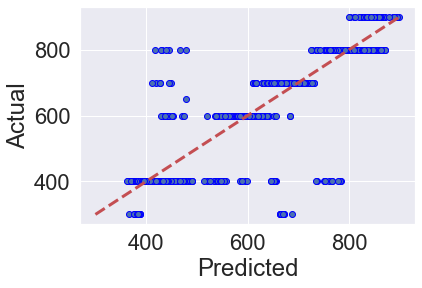

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

In [23]:
pm.lr_plot(Y_test, Y_predict)

In [24]:
co2_sp_null_x = GH_process[GH_process.co2_sp.isna()].iloc[:,1:].drop(columns=['co2_sp'])

In [25]:
column_with_NA = ut.cal_missing_ratio(co2_sp_null_x).index.to_list()
co2_sp_null_x.drop(columns = column_with_NA, inplace=True)
co2_sp_null_y_predict = lr.predict(co2_sp_null_x)
co2_sp_null_x['co2_sp_predict'] = co2_sp_null_y_predict
GH_process.co2_sp.fillna(co2_sp_null_x.co2_sp_predict, inplace=True)

### Check missing value in columns LED lamps vip and LED lamps set point
According to correlation heatmap in dataset. LED lamps vip values (int_blue_vip, int_farred_vip, int_white_vip, int_red_vip) are correlated to AssimLight. After exploring further, I decided to fill the missing value for LED lamps vip depending on AssimLight(on/off).

In [26]:
GH_process[GH_process.AssimLight== 0.0][['int_blue_vip','int_farred_vip','int_red_vip','int_white_vip']].describe()

,int_blue_vip,int_farred_vip,int_red_vip,int_white_vip
count,1104.000000,1104.000000,1104.000000,1104.000000
mean,137.681159,14.492754,137.681159,137.681159
std,344.721186,119.564471,344.721186,344.721186
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1000.000000,1000.000000,1000.000000,1000.000000


In [27]:
GH_process[GH_process.AssimLight== 100.0][['int_blue_vip','int_farred_vip','int_red_vip','int_white_vip']].describe()

,int_blue_vip,int_farred_vip,int_red_vip,int_white_vip
count,24250.000000,24250.000000,24250.000000,24250.000000
mean,961.061814,97.752495,961.177278,961.560082
std,193.120553,296.428005,192.808291,191.714871
min,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,0.000000,1000.000000,1000.000000
50%,1000.000000,0.000000,1000.000000,1000.000000
75%,1000.000000,0.000000,1000.000000,1000.000000
max,1000.000000,1000.000000,1000.000000,1000.000000


In [28]:
int_blue_mean_Lon = GH_process[GH_process.AssimLight== 100.0].int_blue_vip.mean()
int_farred_mean_Lon = GH_process[GH_process.AssimLight== 100.0].int_farred_vip.mean()
int_red_mean_Lon = GH_process[GH_process.AssimLight== 100.0].int_red_vip.mean()
int_white_mean_Lon = GH_process[GH_process.AssimLight== 100.0].int_white_vip.mean()


GH_process.loc[(GH_process.AssimLight== 100.0) & 
               (GH_process.int_blue_vip.isna()),'int_blue_vip'] = int_blue_mean_Lon
GH_process.loc[(GH_process.AssimLight== 100.0) & 
               (GH_process.int_farred_vip.isna()),'int_farred_vip'] = int_farred_mean_Lon
GH_process.loc[(GH_process.AssimLight== 100.0) & 
               (GH_process.int_red_vip.isna()),'int_red_vip'] = int_red_mean_Lon
GH_process.loc[(GH_process.AssimLight== 100.0) & 
               (GH_process.int_white_vip.isna()),'int_white_vip'] = int_white_mean_Lon


int_blue_mean_Loff = GH_process[GH_process.AssimLight== 0.0].int_blue_vip.mean()
int_farred_mean_Loff = GH_process[GH_process.AssimLight== 0.0].int_farred_vip.mean()
int_red_mean_Loff = GH_process[GH_process.AssimLight== 0.0].int_red_vip.mean()
int_white_mean_Loff = GH_process[GH_process.AssimLight== 0.0].int_white_vip.mean()

GH_process.loc[(GH_process.AssimLight== 0.0) & 
               (GH_process.int_blue_vip.isna()),'int_blue_vip'] = int_blue_mean_Loff
GH_process.loc[(GH_process.AssimLight== 0.0) & 
               (GH_process.int_farred_vip.isna()),'int_farred_vip'] = int_farred_mean_Loff
GH_process.loc[(GH_process.AssimLight== 0.0) & 
               (GH_process.int_red_vip.isna()),'int_red_vip'] = int_red_mean_Loff
GH_process.loc[(GH_process.AssimLight== 0.0) & 
               (GH_process.int_white_vip.isna()),'int_white_vip'] = int_white_mean_Loff

check how many rows in farred/white sp has the same value in vip

In [29]:
ut.match_columns(GHclimate[GHclimate.AssimLight== 0.0], 'int_farred_sp','int_farred_vip')

,state,count ratio
0,no match,0.98698
1,mach,0.01302


In [30]:
ut.match_columns(GHclimate[GHclimate.AssimLight== 100.0], 'int_white_sp','int_white_vip')

,state,count ratio
0,mach,0.958692
1,no match,0.041308


In [31]:
int_farred_mean_Lon = GH_process[GH_process.AssimLight== 100.0].int_farred_vip.mean()
int_farred_mean_Loff = GH_process[GH_process.AssimLight== 0.0].int_farred_vip.mean()

GH_process.loc[(GH_process.AssimLight== 100.0) & 
               (GH_process.int_farred_sp.isna()),'int_farred_sp'] = int_farred_mean_Lon
GH_process.loc[(GH_process.AssimLight== 0.0) & 
               (GH_process.int_farred_sp.isna()),'int_farred_sp'] = int_farred_mean_Loff

In [32]:
int_white_mean_Lon = GH_process[GH_process.AssimLight== 100.0].int_white_vip.mean()
int_white_mean_Loff = GH_process[GH_process.AssimLight== 0.0].int_white_vip.mean()

GH_process.loc[(GH_process.AssimLight== 100.0) & 
               (GH_process.int_white_sp.isna()),'int_white_sp'] = int_white_mean_Lon
GH_process.loc[(GH_process.AssimLight== 0.0) & 
               (GH_process.int_white_sp.isna()),'int_white_sp'] = int_white_mean_Loff

Check for missing value in temperature columns (t_heat_sp, t_rail_min_sp, t_vent_sp)

In [33]:
print('Average different between heating temperature set point and vip is ', (GH_process['t_heat_sp']-GH_process['t_heat_vip']).mean())

Average different between heating temperature set point and vip is  -0.15246703344686044


Fill NA of t_heat_sp with t_heat vip

In [34]:
GH_process.t_heat_sp.fillna(GH_process.t_heat_vip, inplace=True)

In [35]:
ut.match_columns(GH_process, 't_rail_min_sp','t_rail_min_vip')

,state,count ratio
0,mach,0.959108
1,no match,0.040892


95% of t_rail_min_sp have the same values of t_rail_min_vip

In [36]:
GH_process.t_rail_min_sp.fillna(GH_process.t_rail_min_vip, inplace=True)

In [37]:
ut.match_columns(GH_process, 't_vent_sp','t_ventwind_vip')

,state,count ratio
0,no match,0.999853
1,mach,0.000147


99% t_vent_sp have the same values of t_ventwind_vip

In [38]:
GH_process.t_vent_sp.fillna(GH_process.t_ventwind_vip, inplace=True)

### Lee  side window sp and vip have very small different value, thus we fill NA in column window_pos_lee_sp with window_pos_lee_vip value

In [39]:
ut.match_columns(GH_process, 'window_pos_lee_sp', 'window_pos_lee_vip')

,state,count ratio
0,mach,0.880656
1,no match,0.119344


In [40]:
print('Average different between Lee side window position set point and vip is ', (GH_process['window_pos_lee_sp']-GH_process['window_pos_lee_vip']).mean())

Average different between Lee side window position set point and vip is  0.002085608211399869


In [41]:
GH_process.window_pos_lee_sp.fillna(GH_process.window_pos_lee_vip, inplace=True)

In [42]:
GH_process.head()

,%time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,Rhair,Tair,Tot_PAR,Tot_PAR_Lamps,VentLee,Ventwind,assim_sp,assim_vip,co2_dos,co2_sp,co2_vip,dx_sp,dx_vip,int_blue_sp,int_blue_vip,int_farred_sp,int_farred_vip,int_red_sp,int_red_vip,int_white_sp,int_white_vip,pH_drain_PC,scr_blck_sp,scr_blck_vip,scr_enrg_sp,scr_enrg_vip,t_grow_min_vip,t_heat_sp,t_heat_vip,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,0.0,35.0,472.0,0.4,4.0,100.0,7.2,0.0,45.2,60.6,20.9,0.0,0.0,1.0,0.0,0.0,0.0,0.002166,420.388713,400.0,2.2,2.2,869.711822,137.681159,14.492754,14.492754,869.711822,137.681159,137.681159,137.681159,6.3,96.0,96.0,100.0,100.0,10.0,21.0,21.0,0.0,0.0,26.0,25.0,26.0,4.0,1950.0,1000.0,1.2,1.2
1,43815.00347,0.0,85.0,501.0,0.5,4.0,100.0,6.9,0.0,43.6,61.4,20.7,0.0,0.0,1.0,0.0,0.0,0.0,0.000300,402.745414,400.0,2.2,2.2,0.000000,137.681159,0.000000,14.492754,0.000000,137.681159,0.000000,137.681159,6.3,96.0,96.0,100.0,100.0,10.0,21.0,21.0,0.0,0.0,26.0,25.0,26.0,6.0,1950.0,1000.0,1.2,1.2
2,43815.00694,0.0,96.0,489.0,0.5,4.0,100.0,7.2,0.0,42.3,60.9,21.2,0.0,0.0,1.0,0.0,0.0,0.0,0.000400,397.732093,400.0,2.2,2.2,0.000000,137.681159,0.000000,14.492754,0.000000,137.681159,0.000000,137.681159,6.3,96.0,96.0,100.0,100.0,10.0,21.0,21.0,0.0,0.0,26.0,25.0,26.0,6.0,1950.0,1000.0,1.2,1.2
3,43815.01042,0.0,96.0,497.0,0.5,4.0,100.0,6.7,0.0,41.2,62.5,20.7,0.0,0.0,1.0,0.0,0.0,0.0,0.002000,398.361764,400.0,2.2,2.2,0.000000,137.681159,0.000000,14.492754,0.000000,137.681159,0.000000,137.681159,6.3,96.0,96.0,100.0,100.0,10.0,21.0,21.0,0.0,0.0,26.0,25.0,26.0,6.0,1950.0,1000.0,1.2,1.2
4,43815.01389,0.0,96.0,477.0,0.5,4.0,100.0,6.7,0.0,41.2,62.7,20.7,0.0,0.0,1.0,0.0,0.0,0.0,0.001600,397.490236,400.0,2.2,2.2,0.000000,137.681159,0.000000,14.492754,0.000000,137.681159,0.000000,137.681159,6.3,96.0,96.0,100.0,100.0,10.0,21.0,21.0,0.0,0.0,26.0,25.0,26.0,6.0,1950.0,1000.0,1.2,1.2


## Feature scaling

In [43]:
GH_process_scaled = pm.scaling_features(GH_process.iloc[:,2:], GH_process.iloc[:,2:].columns.to_list())

/Users/pattama/Desktop/challenge/analysis/process_ML.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Evaluate Algorithms

In [44]:
X = GH_process_scaled
Y = GH_process[['AssimLight']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((38188, 47), (38188, 1), (9548, 47), (9548, 1))

In [45]:
Y_train.head()

,AssimLight
28825,100.0
3997,0.0
24272,100.0
28549,100.0
11577,100.0


In [46]:
models = pm.GetBasedModel()
models

[('LR', LogisticRegression()),
 ('LDA', LinearDiscriminantAnalysis()),
 ('KNN', KNeighborsClassifier()),
 ('CART', DecisionTreeClassifier()),
 ('NB', GaussianNB()),
 ('SVM', SVC(probability=True)),
 ('AB', AdaBoostClassifier()),
 ('GBM', GradientBoostingClassifier()),
 ('RF', RandomForestClassifier()),
 ('ET', ExtraTreesClassifier())]

In [47]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        print(name)
        kfold = StratifiedKFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [48]:
names,results = BasedLine2(X_train, Y_train,models)

LR
LR: 0.999214 (0.000406)
LDA
LDA: 0.994239 (0.001340)
KNN
KNN: 0.999188 (0.000413)
CART
CART: 0.999843 (0.000209)
NB
NB: 0.995575 (0.000997)
SVM
SVM: 0.999398 (0.000352)
AB
AB: 1.000000 (0.000000)
GBM
GBM: 1.000000 (0.000000)
RF
RF: 0.999895 (0.000174)
ET
ET: 0.999895 (0.000240)


In [49]:
class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)
        return data

In [50]:
PlotBoxR().PlotResult(names,results)

[Box({
     'marker': {'color': 'rgb(0, 128, 128)'},
     'name': 'LR',
     'y': array([0.9994763 , 0.99921445, 0.99921445, 0.99816706, 0.9994763 , 0.99895261,
                 0.99973815, 0.99921445, 0.99947617, 0.99921425])
 }),
 Box({
     'marker': {'color': 'rgb(0, 128, 128)'},
     'name': 'LDA',
     'y': array([0.99266824, 0.99293009, 0.99397748, 0.99371563, 0.99554857, 0.99607227,
                 0.99371563, 0.99266824, 0.99659508, 0.99449974])
 }),
 Box({
     'marker': {'color': 'rgb(0, 128, 128)'},
     'name': 'KNN',
     'y': array([0.99973815, 0.99895261, 0.99921445, 0.99842891, 0.9994763 , 0.99895261,
                 0.99973815, 0.9994763 , 0.99921425, 0.99869041])
 }),
 Box({
     'marker': {'color': 'rgb(0, 128, 128)'},
     'name': 'CART',
     'y': array([1.        , 0.99973815, 1.        , 1.        , 0.9994763 , 1.        ,
                 1.        , 0.9994763 , 1.        , 0.99973808])
 }),
 Box({
     'marker': {'color': 'rgb(0, 128, 128)'},
     'name': 'N

## Check features importance
Bagged decision trees like Random Forest and Extra Trees can be used to estimate the importance of features

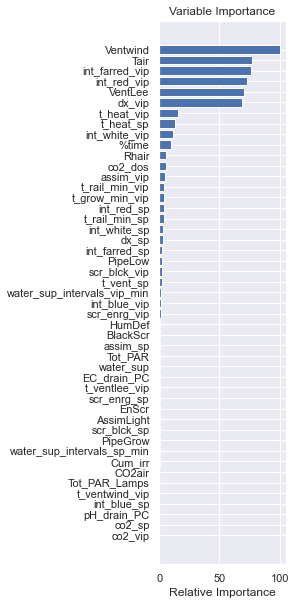

In [55]:
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=1)

clf.fit(X_train, Y_train.values.ravel())

# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

sns.set(font_scale=1)
plt.figure(figsize=(5, 10))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, GH_process.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [56]:
feature_importance_df = pd.DataFrame(feature_importance[sorted_idx[::-1]], index=GH_process.columns[sorted_idx[::-1]], columns=['%FeatureImportance'])

In [57]:
feature_importance_df.head(10)

,%FeatureImportance
Ventwind,100.000000
Tair,76.788714
int_farred_vip,76.489806
int_red_vip,72.448802
VentLee,70.242516
dx_vip,69.054063
t_heat_vip,15.588735
t_heat_sp,12.932546
int_white_vip,11.255221
%time,9.683892
